In [11]:
import segyio
import glob
import os
import numpy as np
from time import time
from math import floor
from util import *

from Configs.RTM_config_model import model_param

os.environ["CUPY_PYLOPS"] = "0"
from pylops import Spread
from pylops.utils import dottest
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

# NMO
---
### CDP-OFFSET seismogramm preparation

In [2]:
# folder_path = '/home/spaceswimmer/Documents/NeoGen_Modeling/Results/2D_vankor/Regular'
folder_path = '/home/artem/Documents/Seismic_modeling/Results/2d_vankor/Regular'
sgy_path = glob.glob(folder_path+'/*.sgy')

In [3]:
#Collect all traces from sgy
for i, sgy in enumerate(sgy_path):
    src = segyio.open(sgy, mode='r', endian='big', ignore_geometry=True)
    samples = src.samples
    data = segyio.tools.collect(src.trace[:])
    sou_x = src.attributes(segyio.TraceField.SourceX)[:]/100
    rec_x = src.attributes(segyio.TraceField.GroupX)[:]
    src.close
    if i==0:
        traces = np.empty((len(sgy_path)*data.shape[0],data.shape[1]))
        cdp_x = np.empty(rec_x.shape[0]*len(sgy_path))
        offset =np.empty(rec_x.shape[0]*len(sgy_path))
    traces[data.shape[0]*(i):data.shape[0]*(i+1), :] = data
    cdp_x[rec_x.shape[0]*i:rec_x.shape[0]*(i+1)] = (sou_x+rec_x)/2
    offset[rec_x.shape[0]*i:rec_x.shape[0]*(i+1)] = sou_x-rec_x

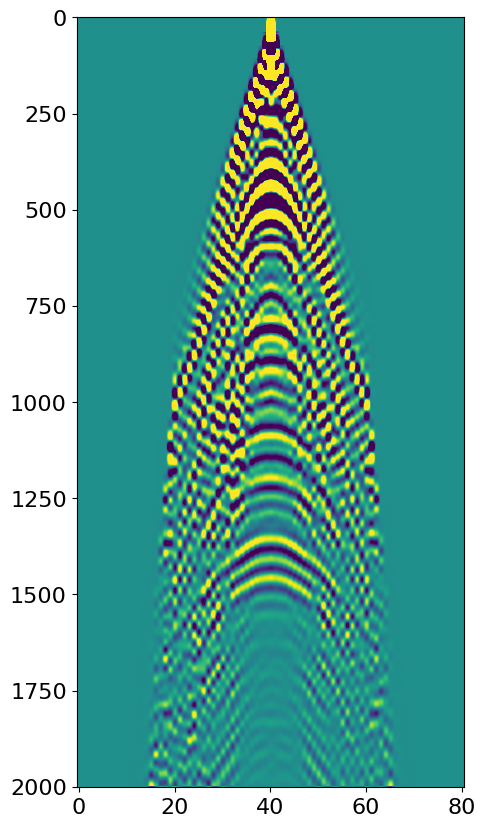

In [4]:
#make cdp seismogram
cdp_ens = {}
cdp_i = 1000
for cdp in np.unique(cdp_x)[cdp_i:cdp_i+1]:
    cdp_idx = cdp_x == cdp
    offset_idx = np.argsort(offset[cdp_idx])
    cdp_sorted = traces[cdp_idx][offset_idx].T
    cdp_ens['cdp'] = cdp_sorted
    cdp_ens['offset'] = offset[cdp_idx][offset_idx]
    cdp_ens['cdp_x'] = np.unique(cdp_x[cdp_idx][offset_idx])[0]


    fig, axs = plt.subplots(figsize=(5,10))
    plt.imshow(cdp_sorted[:,:], aspect='auto', vmin=-np.quantile(cdp_sorted, 0.95), vmax = np.quantile(cdp_sorted, 0.95), )
    plt.show()

### Applying NMO with constant velocity

In [5]:
cdp_ens['cdp_x']

np.float64(2500.0)

In [6]:
def create_tables(taxis, haxis, vels_rms):
    dt = taxis[1] - taxis[0]
    ot = taxis[0]
    nt = len(taxis)
    nh = len(haxis)

    # NaN values will be not be spread.
    # Using np.zeros has the same result but much slower.
    table = np.full((nh, nt, nh), fill_value=np.nan)
    dtable = np.full((nh, nt, nh), fill_value=np.nan)

    for ih, h in enumerate(haxis):
        for it0, (t0, vrms) in enumerate(zip(taxis, vels_rms)):
            # Compute NMO traveltime
            tx = np.sqrt(t0**2 + (h / vrms) ** 2)
            it_frac = (tx - ot) / dt
            it_floor = floor(it_frac)
            w = it_frac - it_floor
            # Both it_floor and it_floor + 1 must be valid indices for taxis
            # when using two tables (interpolation).
            if 0 <= it_floor and it_floor + 1 < nt:
                table[ih, it0, ih] = it_floor
                dtable[ih, it0, ih] = w
    return table, dtable


nmo_table, nmo_dtable = create_tables(samples/1000, cdp_ens['offset'], np.ones_like(samples)*2000)

#operator
SpreadNMO = Spread(
    dims=cdp_ens['cdp'].T.shape,  # "Input" shape: NMO-ed data shape
    dimsd=cdp_ens['cdp'].T.shape,  # "Output" shape: original data shape
    table=nmo_table,  # Table of time indices
    dtable=nmo_dtable,  # Table of weights for linear interpolation
    engine="numpy",  # numba or numpy
).H  # To perform NMO *correction*, we need the adjoint
dottest(SpreadNMO, rtol=1e-4)

np.True_

In [7]:
#summon operator
dnmo_spr = SpreadNMO @ cdp_ens['cdp'].T

start = time()
SpreadNMO @ cdp_ens['cdp'].T
end = time()

print(f"Ran in {1e6*(end-start):.0f} μs")

Ran in 1482508 μs


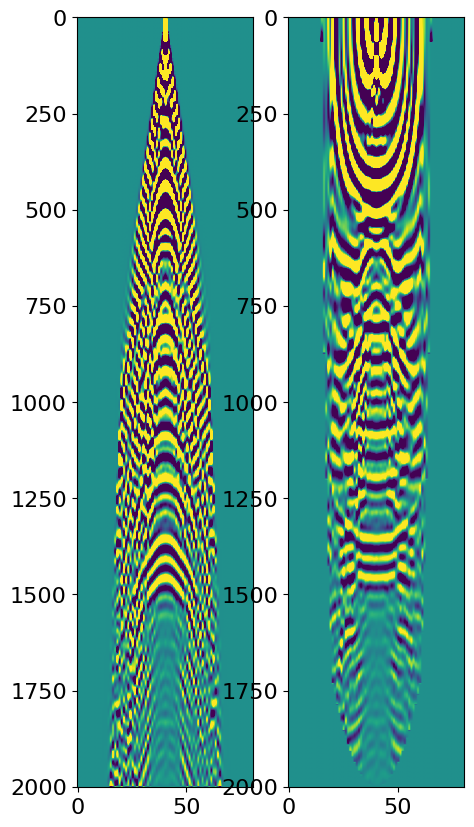

In [8]:
# Plot Data and NMO-corrected data
fig, axs = plt.subplots(1, 2, figsize=(5,10))
axs[0].imshow(cdp_ens['cdp'], aspect='auto', vmin=-np.quantile(cdp_ens['cdp'], 0.9), vmax = np.quantile(cdp_ens['cdp'], 0.9), )
axs[1].imshow(dnmo_spr.T, aspect='auto', vmin=-np.quantile(dnmo_spr, 0.9), vmax = np.quantile(dnmo_spr, 0.9), )

### NMO with model velocities
#### Переводим интервальные скорости в RMS во времени

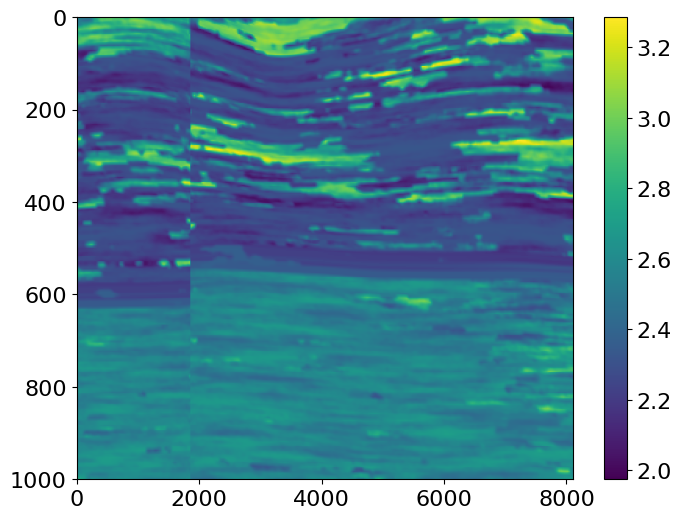

In [12]:
model_vp = np.load(model_param['path'])
plt.imshow(model_vp.T, aspect = 'auto', extent=(0, 8100, 1000, 0))
plt.colorbar()

In [26]:
#Считаем Time Depth Relation
dti = np.empty_like(model_vp)
dti = (2.5)/model_vp/1000
ti = dti.cumsum(axis=1)*2 # делаем это время twt

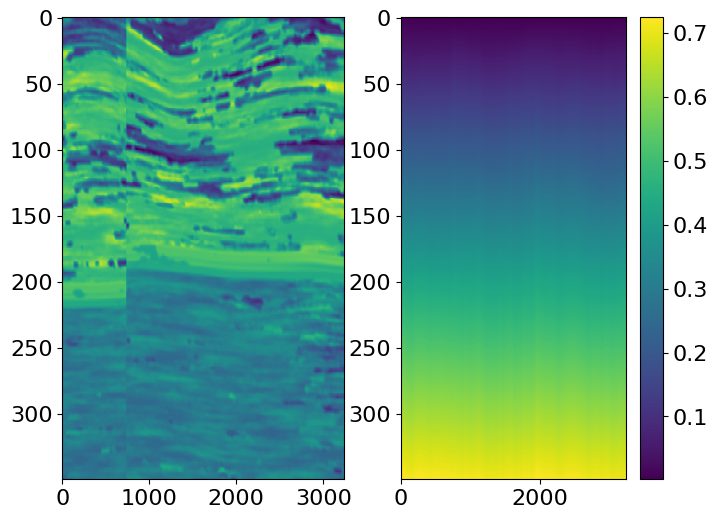

In [27]:
fig, axs = plt.subplots(1,2)
axs[0].imshow(dti.T, aspect='auto')
im = axs[1].imshow(ti.T, aspect='auto')
fig.colorbar(im)

In [15]:
#Считаем RMS скорости в глубине
# vrms = np.sqrt((model_vp**2).cumsum(axis=1)/(np.indices(model_vp.shape)[1]+1))
depth = np.arange(2.5, (model_vp.shape[1]+1)*2.5, 2.5)
vrms = depth[None,:]/(ti/2)
plt.imshow(vrms.T, aspect = 'auto', extent=(0, 8100, model_vp.shape[1]*2.5, 0))
plt.colorbar()

NameError: name 'ti' is not defined

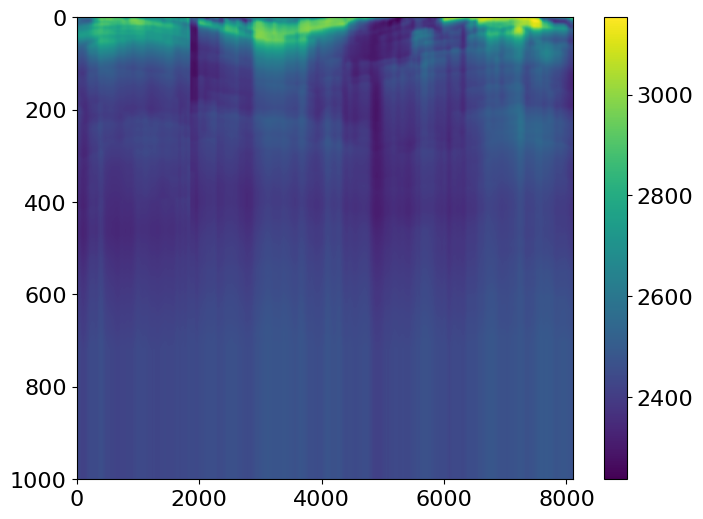

In [39]:
#считаем RMS скорости во времени
dt = np.arange(0,samples[-1]/1000, samples[1]/1000)
vt_rms = np.array([np.interp(dt, i, j) for i, j in zip(ti, vrms)])
plt.imshow(vt_rms.T, aspect = 'auto', extent=(0, 8100, samples.max(), 0))
plt.colorbar()

### Проводим NMO для реальных скоростей

In [44]:
nmo_table, nmo_dtable = create_tables(samples/1000, cdp_ens['offset'], vt_rms[int(cdp_ens['cdp_x']/2.5)])

#operator
SpreadNMO = Spread(
    dims=cdp_ens['cdp'].T.shape,  # "Input" shape: NMO-ed data shape
    dimsd=cdp_ens['cdp'].T.shape,  # "Output" shape: original data shape
    table=nmo_table,  # Table of time indices
    dtable=nmo_dtable,  # Table of weights for linear interpolation
    engine="numpy",  # numba or numpy
).H  # To perform NMO *correction*, we need the adjoint
dottest(SpreadNMO, rtol=1e-4)

np.True_

In [45]:
#summon operator
dnmo_spr = SpreadNMO @ cdp_ens['cdp'].T

start = time()
SpreadNMO @ cdp_ens['cdp'].T
end = time()

print(f"Ran in {1e6*(end-start):.0f} μs")

Ran in 1563375 μs


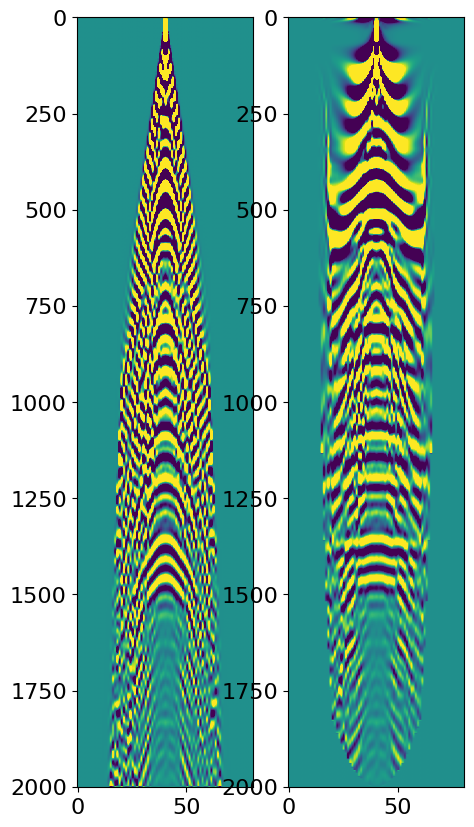

In [47]:
# Plot Data and NMO-corrected data
fig, axs = plt.subplots(1, 2, figsize=(5,10))
axs[0].imshow(cdp_ens['cdp'], aspect='auto', vmin=-np.quantile(cdp_ens['cdp'], 0.9), vmax = np.quantile(cdp_ens['cdp'], 0.9), )
axs[1].imshow(dnmo_spr.T, aspect='auto', vmin=-np.quantile(dnmo_spr, 0.9), vmax = np.quantile(dnmo_spr, 0.9),)

# RTM Migration
---

In [ ]:
from Configs.RTM_config_model import model_param

Вызывать скрипт можно либо прямо из консоли, либо из юпитера  

Запустим скрипт для реальных данных, когда у нас есть только поле отраженных волн и модель.

In [48]:
!python Scripts/RTM_real.py

TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
Model creation finished in: 2.417572259902954 sec
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFu

Теперь посмотрим на результат

<Axes: xlabel='Distance, m', ylabel='Depth, m'>

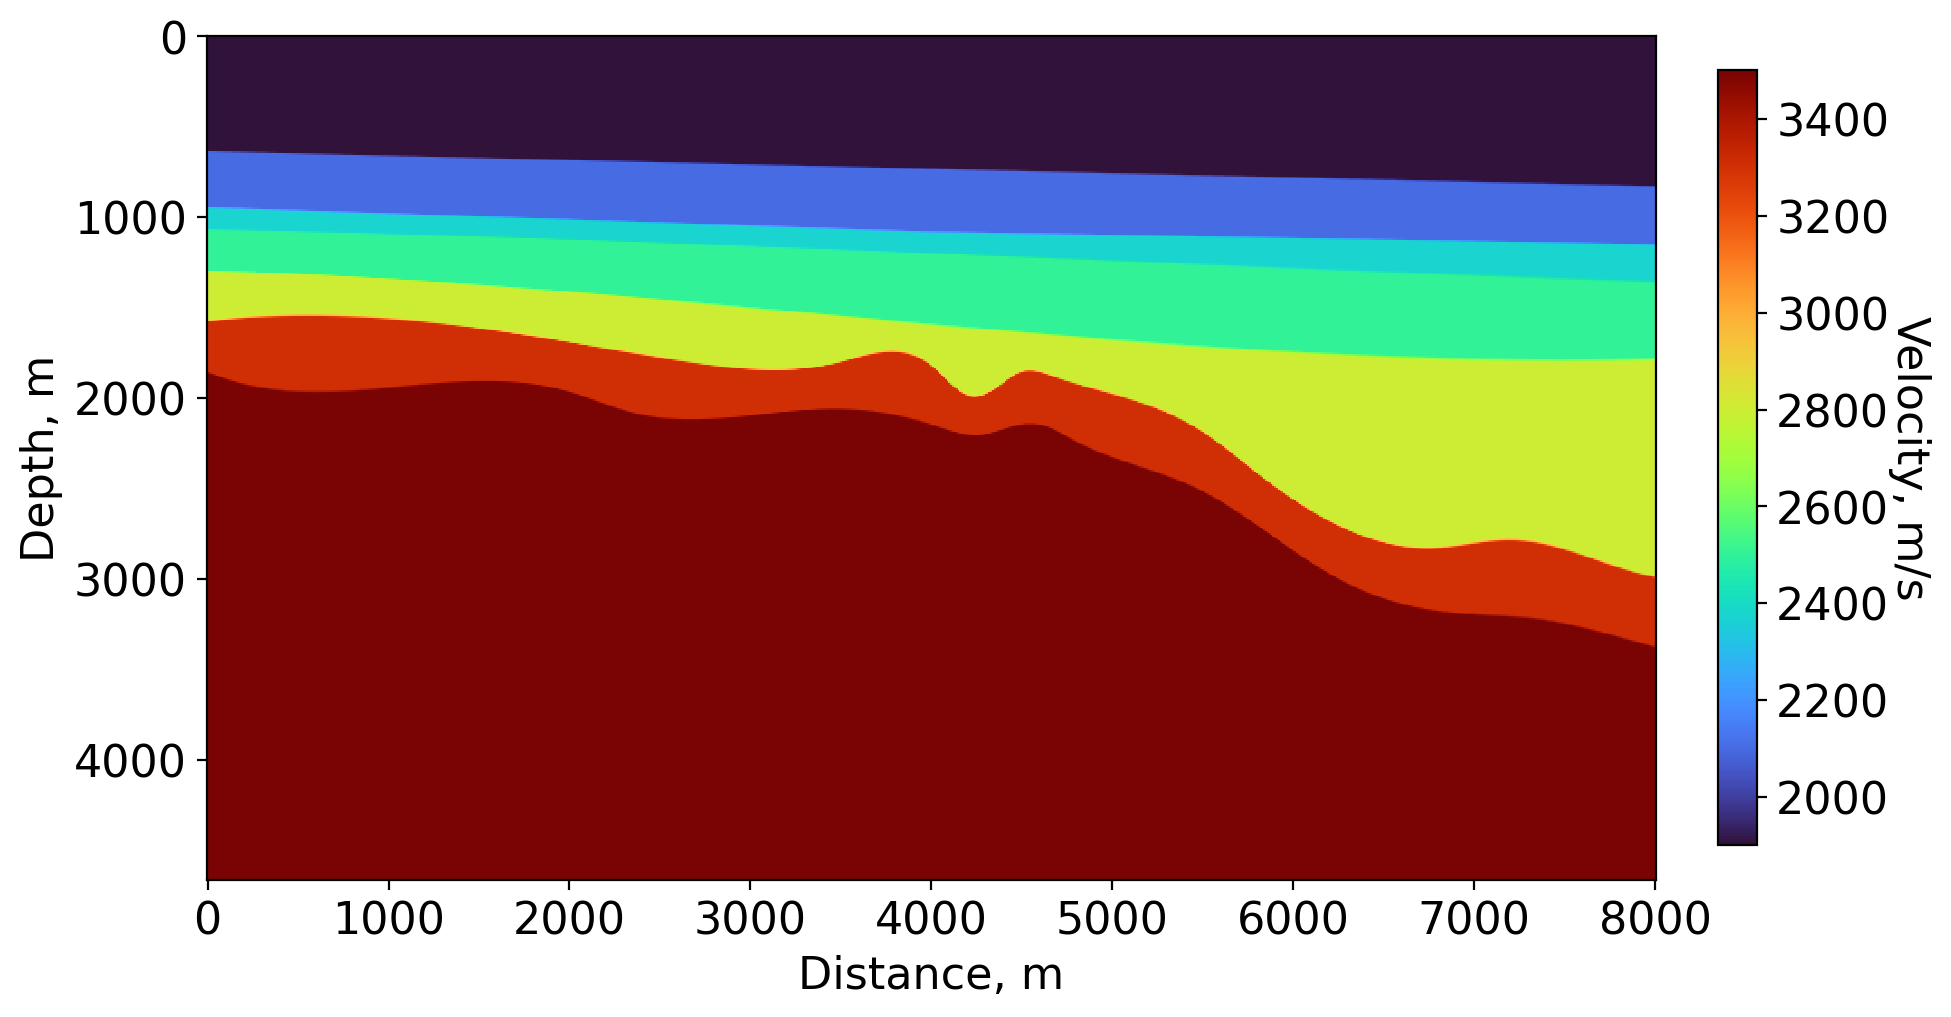

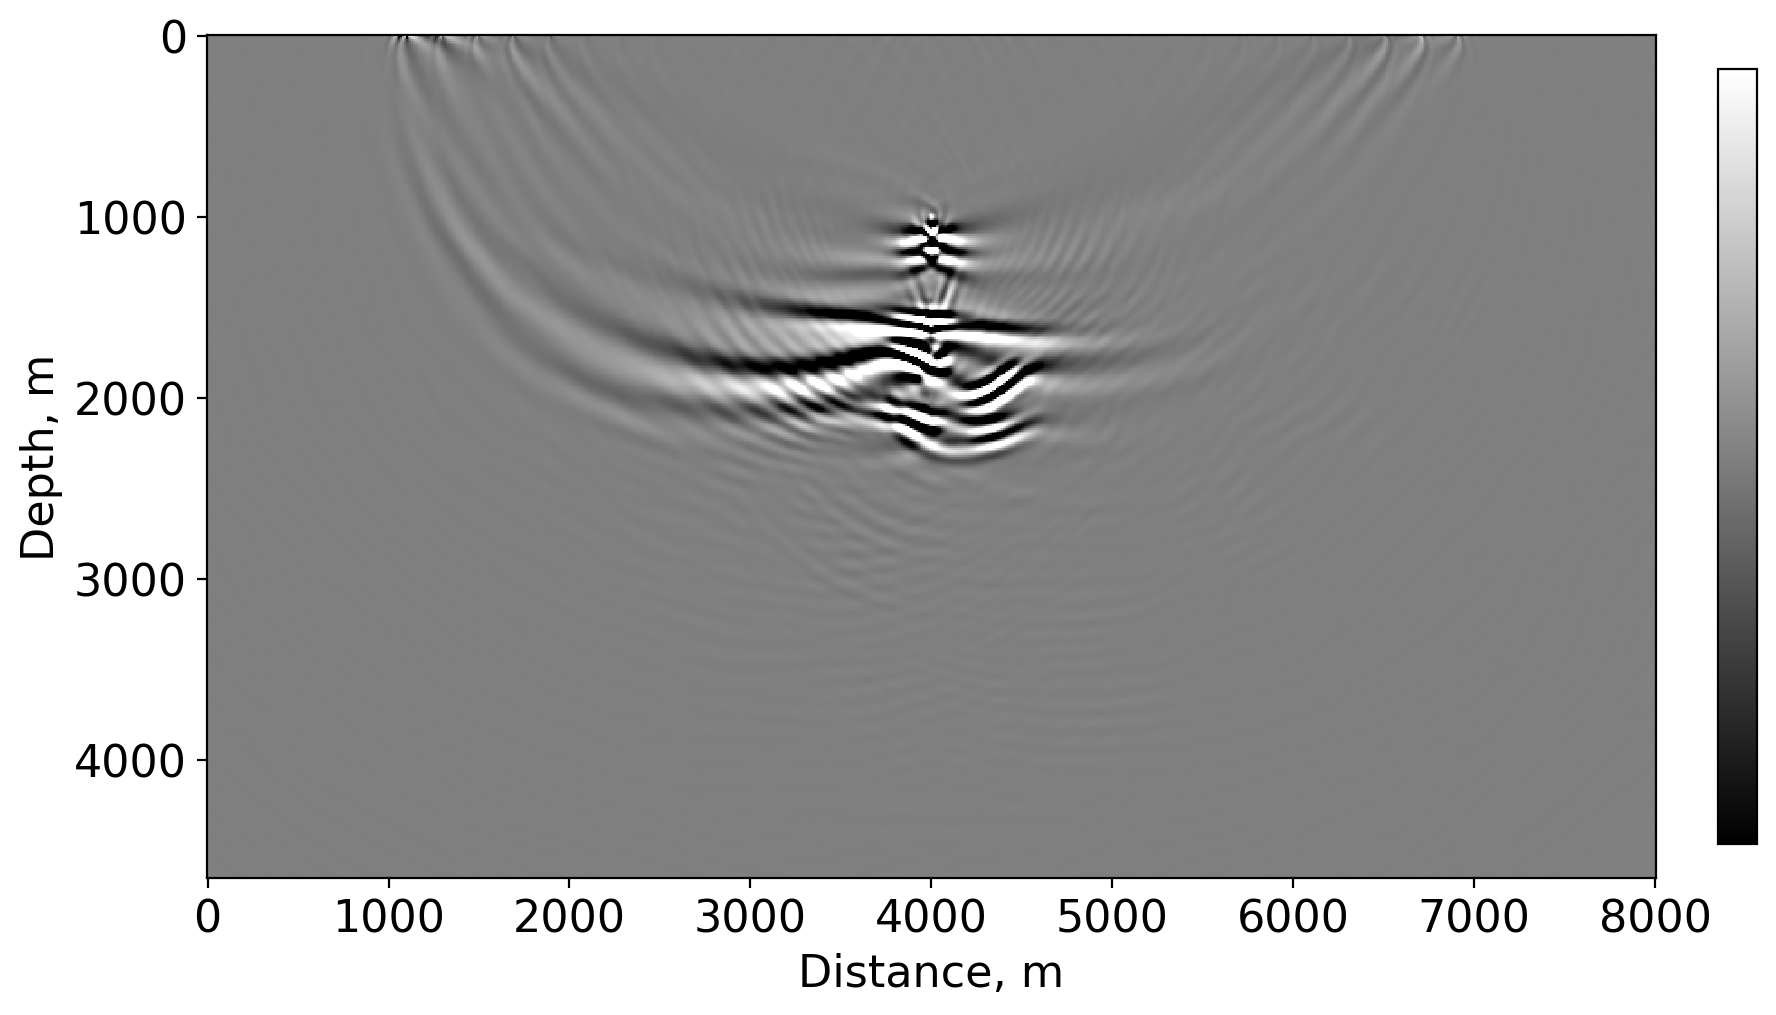

In [6]:
images = np.load('Results/RTM_real_images.npy')
RTM_model_vp, xx, zz = readin_bin(model_param['path'], seek_num=0, nt=467, nr=801, dx=10, dz=10)

slices = [slice(20, -20), slice(20, -20)]
stack_image = np.zeros_like(np.diff(images[0], axis=1))
for im in images:
    stack_image += np.diff(im, axis=1)
    # stack_image += im[:, :-1]

axs = plot_model(np.round(RTM_model_vp, -1), xx, zz, rec=None, src=None, show=False)
# axs.pcolormesh(xx.T[:, :-1], zz.T[:, :-1], stack_image[80:-80, 80:-80], alpha=0.7, cmap='gray', vmin=-np.quantile(stack_image[80:-80, 80:-80], 0.995), vmax=np.quantile(stack_image[80:-80, 80:-80], 0.995))
plot_image(stack_image[20:-20, 20:-20], xx.T[:, :-1], zz.T[:, :-1], quantile=0.995, )
# plt.show()

Запустим теперь скрипт для модельных данных, когда мы имеем только сейсмограммы.  
Рассмотрим на примере следующей модели

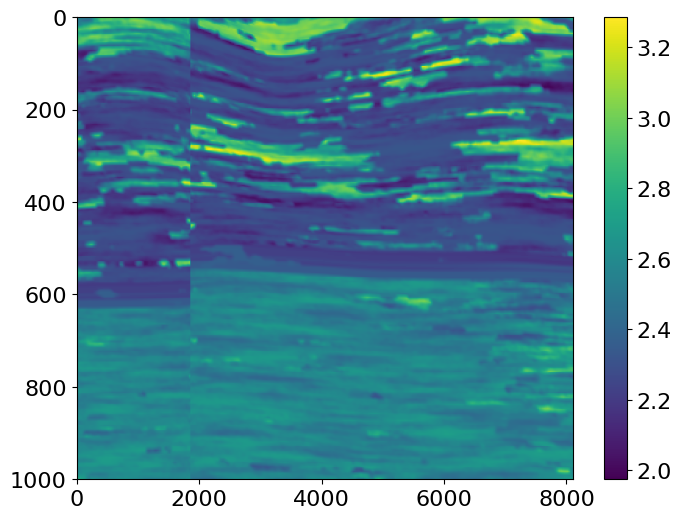

In [13]:
plt.imshow(model_vp.T, aspect = 'auto', extent=(0, 8100, 1000, 0))
plt.colorbar()

In [31]:
!python Scripts/RTM.py

TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
Model creation finished in: 2.4376304149627686 sec
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeF

In [22]:
model_vp.shape

(3241, 350)

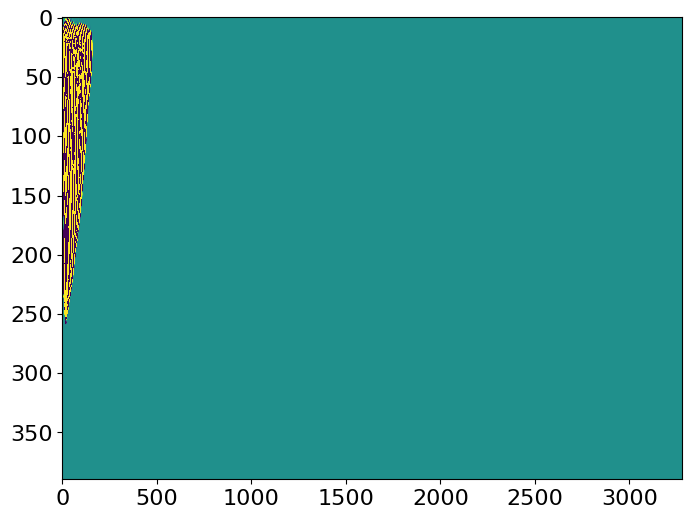

In [39]:
model_images = np.load('Results/RTM_model_images.npy')

stack_image = np.zeros_like(np.diff(model_images[0], axis=1))
for im in model_images:
    stack_image += np.diff(im, axis=1)

image = model_images[0].T
gain = np.quantile(image, 0.99)
plt.imshow(image.T, aspect='auto', vmin=-gain, vmax=gain)

TypeError: Dimensions of C (350, 3240) should be one smaller than X(349) and Y(390) while using shading='flat' see help(pcolormesh)

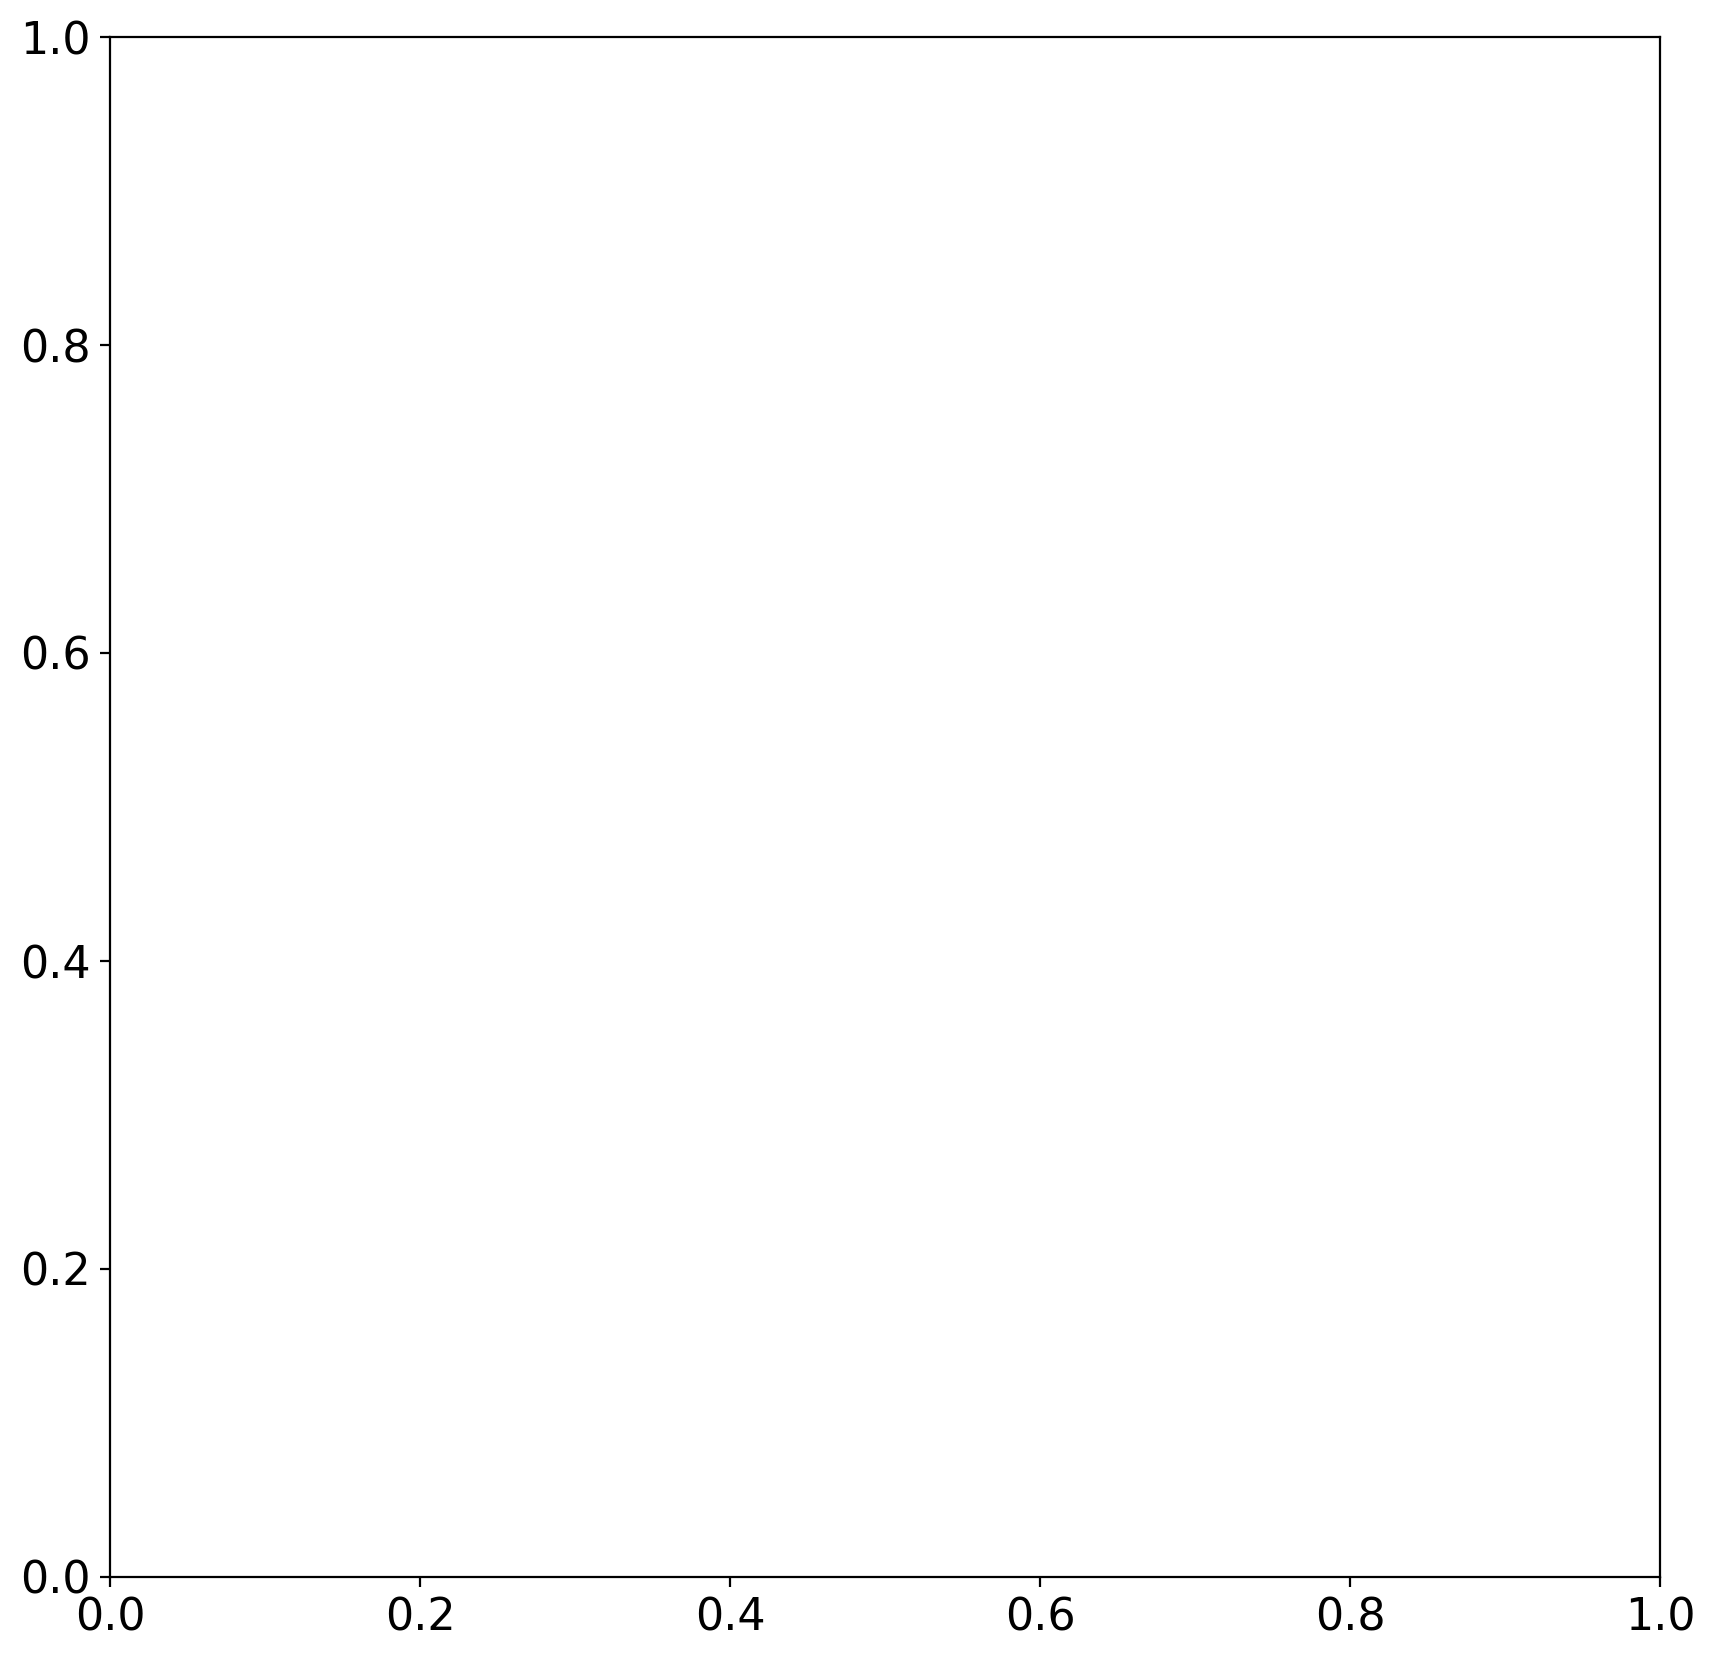

In [19]:
model_images = np.load('Results/RTM_model_images.npy')
x = np.linspace(0, model_images[0], model_images[0].shape[0])
z = depth
xx, zz = np.meshgrid(x, z)
slices = [slice(20, -20), slice(20, -20)]
stack_image = np.zeros_like(np.diff(model_images[0], axis=1))
for im in model_images:
    stack_image += np.diff(im, axis=1)
    # stack_image += im[:, :-1]
# axs.pcolormesh(xx.T[:, :-1], zz.T[:, :-1], stack_image[80:-80, 80:-80], alpha=0.7, cmap='gray', vmin=-np.quantile(stack_image[80:-80, 80:-80], 0.995), vmax=np.quantile(stack_image[80:-80, 80:-80], 0.995))
plot_image(stack_image[20:-20, 20:-20], xx.T[:, :-1], zz.T[:, :-1], quantile=0.995, )
# plt.show()